### Data Collection

In [17]:
from bs4 import BeautifulSoup
import requests
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jahdovanterpool/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Define the base URL for scraping British Airways reviews from AirlineQuality (Skytrax)
# This will serve as the starting point for constructing paginated URLs

base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'

# Each review page can display up to 100 reviews
page_size = 100

# We'll scrape the first 40 pages of reviews
total_pages = 40

# Initialize an empty list to hold all the review dictionaries
reviews = []

# Step 3: Loop through each review page using pagination
for page in range(total_pages + 1):
    print(f"Scraping page {page} of {total_pages} .........")

    # Construct the URL for the current page
    url = f'{base_url}/page/{page}/?sortby=post_date%3ADesc&pagesize={page_size}'

    # Send an HTTP GET request to the page
    response = requests.get(url)

    # Parse the response HTML using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 4: Extract all individual review containers from the HTML
    # Each review is wrapped in an <article> tag with itemprop="review"
    review_containers = soup.find_all('article', {'itemprop': 'review'})

    # Step 5: Loop through each review block and extract data
    for review in review_containers:
        review_dict = {}

        # Extract the title of the review
        title = review.find('h2', {'class': 'text_header'})
        review_dict['title'] = title.get_text(strip=True) if title else None

        # Extract the main review content
        content = review.find('div', {'class': 'text_content', 'itemprop': 'reviewBody'})
        review_dict['content'] = content.get_text(strip=True) if content else None

        # Extract the overall review rating (e.g., 7/10)
        # This is the actual numerical score submitted by the user
        rating_span = review.find('span', itemprop='ratingValue')
        if rating_span:
            try:
                review_dict['rating'] = int(rating_span.get_text(strip=True))
            except ValueError:
                # If the rating is not a valid integer, fall back to None
                review_dict['rating'] = None
        else:
            review_dict['rating'] = None

        # Extract the author's name (if available)
        author = review.find('span', {'itemprop': 'name'})
        review_dict['author'] = author.get_text(strip=True) if author else None

        # Extract the date the review was published
        date = review.find('time', {'itemprop': 'datePublished'})
        if date and date.has_attr('datetime'):
            review_dict['date'] = date['datetime']

        # Check whether the review is marked as "Trip Verified"
        # This helps assess the credibility of the review
        review_dict['verified'] = 'Trip Verified' in content.get_text() if content else False

        # Step 6: Extract additional structured information from the ratings table
        # This includes Aircraft, Route, Seat Type, Comfort, Cabin Staff, etc.
        rows = review.find_all('tr')  # Each <tr> represents a single attribute or rating category

        for row in rows:
            # First <td> is the label (e.g., "Aircraft")
            label_cell = row.find('td', {'class': 'review-rating-header'})
            # Second <td> is the value (e.g., "Boeing 777" or star ratings)
            value_cell = row.find('td', {'class': 'review-value'})

            if label_cell and value_cell:
                # Format the label to be lowercase and underscore-separated for consistency
                key = label_cell.get_text(strip=True).lower().replace(' ', '_')

                # Check if the value includes star icons
                stars = value_cell.find_all('span', {'class': 'star fill'})

                if stars:
                    # If stars are present, count them as a numeric score
                    value = len(stars)
                else:
                    # Otherwise, extract the plain text (e.g., for Aircraft or Route)
                    value = value_cell.get_text(strip=True)

                # Add the field to the current review dictionary
                review_dict[key] = value

        # Step 7: Append the complete review dictionary to the master list
        reviews.append(review_dict)

    # Step 8: Sleep briefly to avoid overwhelming the server (polite scraping)
    time.sleep(2)

In [ ]:
df = pd.DataFrame(reviews)
df.to_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_1.csv', index=False)

### Data Preprocessing

In [ ]:
reviews_df = pd.read_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_1.csv',index_col=False)

reviews_df.head()

In [ ]:
top_missingValue_columns = reviews_df.isnull().sum()\
    .sort_values(ascending=False)\
        .head()

top_missingValue_columns.plot(kind='bar',rot=45)

plt.title('Columns with missing values')

plt.xlabel('Features with missing values')
plt.show()

In [ ]:
# I will focus on a basic sentiment analysis (content & rating)
reduced_df = reviews_df.drop(columns=['aircraft','type_of_traveller','route','date_flown'],axis=0)

In [ ]:
reduced_df.head()

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower()
    text = re.sub(r"[^\w\s]"," ", text)

    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]
    return ' '.join(cleaned_tokens)

reduced_df['cleaned_content'] = reduced_df['content'].apply(clean_text)
reduced_df.head()

In [ ]:
reduced_df

In [ ]:
import random

i = random.randint(0,len(reduced_df))
print(i)
print("Original: ", reduced_df.loc[i,'content'])
print('\n')
print('Cleaned comment: ',reduced_df.loc[i,'cleaned_content'])

In [ ]:
reduced_df.to_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_2.csv', index=False)

### Sentiment

In [ ]:
vader_df = pd.read_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_2.csv',index_col=False)

vader_df.sample(10)

In [ ]:
vader_df.isnull().sum()

In [ ]:
vader_df.dropna(axis=0,inplace=True)

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
vader_df['Sentiment_score'] = vader_df['cleaned_content'].apply(lambda x: sia.polarity_scores(x)['compound'])

def rating_sentiment(rating):
    if rating >= 7:
        return 'Positive'
    elif rating <= 3:
        return 'Negative'
    else:
        return 'Neutral'

def label_sentiment(score):
    if score >= 0.5:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

vader_df['sentiment_label'] = vader_df['Sentiment_score'].apply(lambda x: label_sentiment(x))
vader_df['rating_sentiment_label'] = vader_df['rating'].apply(lambda x: rating_sentiment(x))

In [ ]:
vader_df.head()

In [ ]:
vader_df['match'] = vader_df['sentiment_label'] == vader_df['rating_sentiment_label']
vader_df['match'].value_counts()


In [ ]:
agreement_by_rating = vader_df.groupby('rating')['match'].mean()
agreement_by_rating.plot(kind='bar',title='Agreement by rating')


### Sentiment - Transformer

In [3]:
df = pd.read_csv('/Users/jahdovanterpool/Downloads/Projects/Sentiment Analysis/British_Airways_reviews_2.csv',index_col=False)


df.sample(10)

,title,content,rating,author,date,verified,seat_type,recommended,cleaned_content
2528,"""generous with the amount of food""",Toronto to Entebbe via London with British Air...,9.0,Matthew Rooyakkers,2016-07-07,False,Economy Class,yes,toronto entebbe via london british airway quit...
1061,"""glorified budget airline""",✅Trip Verified| London to Athens. British Airw...,5.0,H Smith,2019-10-16,True,Economy Class,no,trip verified london athens british airway glo...
3482,British Airways customer review,Los Angeles (LAX) to London (LHR) in Club Worl...,10.0,James Little,2015-01-26,False,Business Class,yes,los angeles lax london lhr club world january ...
3843,British Airways customer review,I have used BA over the past 20 years as I cho...,4.0,Brenda Watkinson,2014-07-29,False,Economy Class,no,used ba past year chose move airmiles plan reg...
2327,"""excellent service overall""",Dallas/Fort Worth to London Heathrow. Excellen...,9.0,J Lemon,2016-11-15,False,First Class,yes,dallas fort worth london heathrow excellent se...
1201,"""first class experience""",✅Trip Verified| London to Delhi. A truly firs...,8.0,L Gill,2019-06-02,True,First Class,yes,trip verified london delhi truly first class e...
2999,"""you could care less""",We paid for World Traveller Plus (Premium Econ...,2.0,E Ohler,2015-10-07,False,Premium Economy,no,paid world traveller plus premium economy brit...
3680,British Airways customer review,OSL-LHR in Business. BA has over the last few ...,3.0,E Eriksson,2014-10-22,False,Business Class,no,osl lhr business ba last year put less priorit...
3040,"""Club Europe is poor value""",London Heathrow to Kos return. Outbound the Ga...,5.0,David Ellis,2015-09-20,False,Business Class,no,london heathrow ko return outbound gallery sou...
3084,"""need to up their game""","On the upper deck on BA 282 (Aug 31st), althou...",3.0,David Passmore,2015-09-02,False,Business Class,no,upper deck ba aug although equipment relativel...


In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline('sentiment-analysis', framework='pt',tokenizer=tokenizer,model=model)

df['sentiment'] = df['cleaned_content'].apply(lambda x: int(sentiment_pipeline(x[:512])[0]['label'].split()[0]))
df.head()

Device set to use mps:0


,title,content,rating,author,date,verified,seat_type,recommended,cleaned_content,sentiment
0,“staff were really engaged”,✅Trip Verified| Having had some rough experien...,7.0,A Karlsson,2025-04-16,True,Economy Class,yes,trip verified rough experience ba recent year ...,3
1,"""got it right on this flight""",✅Trip Verified| This comfortable flight was ...,9.0,T Morton,2025-04-16,True,First Class,yes,trip verified comfortable flight ba best excel...,4
2,"""exceeded my expectations""",Not Verified| Punta Cana Terminal B check in ...,9.0,Jacqueline Heap,2025-04-15,False,Business Class,yes,verified punta cana terminal b check straightf...,3
3,"""checkin was very rude to us""",✅Trip Verified| The employee at Venice Airpo...,3.0,D Gale,2025-04-13,True,Economy Class,no,trip verified employee venice airport checkin ...,1
4,"""forced to check-in carry-ons""","✅Trip Verified| I had only 1 bag with me, a ...",1.0,R Hardin,2025-04-12,True,Economy Class,no,trip verified bag carry trolley everyone one b...,1


In [6]:
sentiment_df = df.copy()
sentiment_df = sentiment_df[['title', 'cleaned_content', 'rating', 'sentiment']]
sentiment_df.head()

,title,cleaned_content,rating,sentiment
0,“staff were really engaged”,trip verified rough experience ba recent year ...,7.0,3
1,"""got it right on this flight""",trip verified comfortable flight ba best excel...,9.0,4
2,"""exceeded my expectations""",verified punta cana terminal b check straightf...,9.0,3
3,"""checkin was very rude to us""",trip verified employee venice airport checkin ...,3.0,1
4,"""forced to check-in carry-ons""",trip verified bag carry trolley everyone one b...,1.0,1


In [7]:
def label_rating_sentiment(rating):
    if rating >= 8:
        return 'Positive'
    elif rating <= 3:
        return 'Negative'
    else:
        return 'Neutral'

def label_score_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

sentiment_df.loc[:,'rating_sentiment'] = sentiment_df['rating'].apply(lambda x: label_rating_sentiment(x))
sentiment_df.loc[:,'score_sentiment'] = sentiment_df['sentiment'].apply(lambda x: label_score_sentiment(x))

In [8]:
sentiment_df

,title,cleaned_content,rating,sentiment,rating_sentiment,score_sentiment
0,“staff were really engaged”,trip verified rough experience ba recent year ...,7.0,3,Neutral,Neutral
1,"""got it right on this flight""",trip verified comfortable flight ba best excel...,9.0,4,Positive,Positive
2,"""exceeded my expectations""",verified punta cana terminal b check straightf...,9.0,3,Positive,Neutral
3,"""checkin was very rude to us""",trip verified employee venice airport checkin ...,3.0,1,Negative,Negative
4,"""forced to check-in carry-ons""",trip verified bag carry trolley everyone one b...,1.0,1,Negative,Negative
...,...,...,...,...,...,...
4027,British Airways customer review,flight heathrow toronto booked emergency exit ...,7.0,3,Neutral,Neutral
4028,British Airways customer review,lhr ham purser address club passenger name boa...,9.0,5,Positive,Positive
4029,British Airways customer review,son worked british airway urged fly british ai...,5.0,1,Neutral,Negative
4030,British Airways customer review,london city new york jfk via shannon really ni...,4.0,4,Neutral,Positive


In [9]:
sentiment_df['match'] = sentiment_df['score_sentiment'] == sentiment_df['rating_sentiment']
sentiment_df['match'].value_counts()

match
True     2739
False    1293
Name: count, dtype: int64

<Axes: xlabel='rating'>

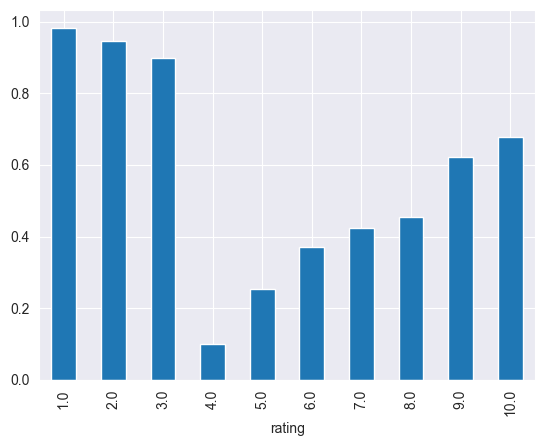

In [10]:
agreement_by_rating = sentiment_df.groupby('rating')['match'].mean()
agreement_by_rating.plot(kind='bar')

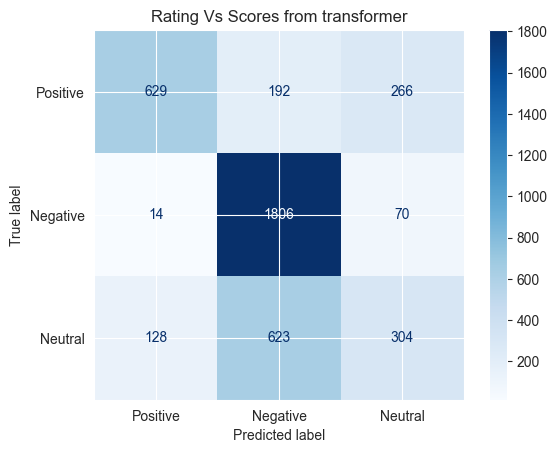

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(sentiment_df['rating_sentiment'], sentiment_df['score_sentiment'], labels=['Positive', 'Negative', 'Neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative', 'Neutral'])
disp.plot(cmap='Blues')
plt.title('Rating Vs Scores from transformer')
plt.show()

### Topic Modeling

In [2]:
import numpy as np
import pandas as pd
import gensim
from gensim import corpora

In [15]:
texts  = df['cleaned_content'].str.split()
dict = corpora.Dictionary(texts)
dict.filter_extremes(no_below=5, no_above=0.5)
corpus = [dict.doc2bow(text) for text in texts]


In [16]:
lda = gensim.models.LdaModel(corpus=corpus,
                             id2word=dict,
                             num_topics=10,
                             random_state=42,
                             passes=10
                             )
for tid, wp in lda.show_topics(formatted=False):
    print(f"Topic {tid}: {', '.join(w for w,_ in wp)}")

Topic 0: fast, gate, track, bag, lhr, one, bus, ok, british, airway
Topic 1: plane, back, told, get, way, long, part, coming, bag, minute
Topic 2: economy, premium, aisle, business, meal, food, class, choice, fly, airline
Topic 3: tasty, new, nice, jfk, good, york, london, professional, city, via
Topic 4: class, business, service, club, economy, airline, food, drink, lounge, cabin
Topic 5: food, cabin, crew, time, good, london, airway, british, service, airline
Topic 6: hour, customer, u, day, would, british, airway, service, told, london
Topic 7: cabin, club, lhr, breakfast, better, world, food, service, choice, good
Topic 8: crew, lhr, food, service, lounge, excellent, good, boarding, time, check
Topic 9: american, told, called, chicago, airway, british, booked, airline, journey, back


### Word cloud & keywords

In [18]:
from wordcloud import WordCloud

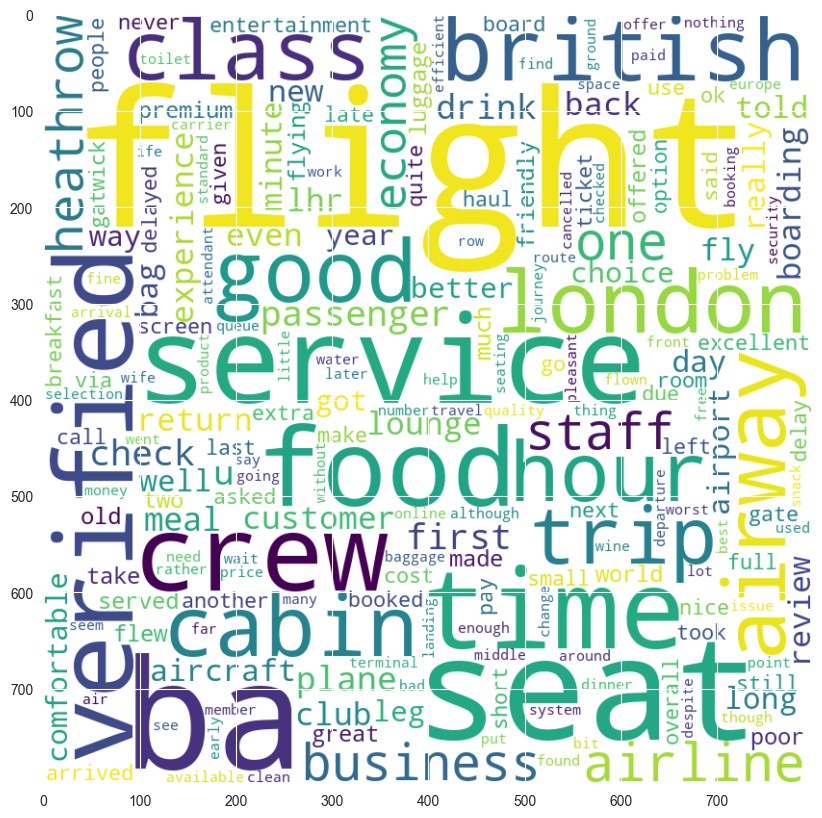

In [19]:
all_text = " ".join(df['cleaned_content'])
wc = WordCloud(width = 800, height = 800, background_color = 'white', collocations = False)
wc.generate(all_text)

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)


def get_keywords(corpus):
    X = vectorizer.fit_transform(corpus)
    keywords = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    return sorted(zip(keywords, counts), key=lambda x: x[1], reverse=True)


positive_comments = sentiment_df[sentiment_df['rating'] >= 7]['cleaned_content']
negative_comments = sentiment_df[sentiment_df['rating'] <= 3]['cleaned_content']

print("Top Positive Keywords")
positive = {}
for word, count in get_keywords(positive_comments):
    positive[word] = int(count)
print(positive)

print("\n")
print("Top Negative Keywords")
negative = {}
for word, count in get_keywords(negative_comments):
    negative[word] = int(count)
print(negative)

Top Positive Keywords
{'flight': 2832, 'seat': 1495, 'good': 1444, 'ba': 1385, 'crew': 1127, 'service': 1054, 'food': 1026, 'time': 1014, 'cabin': 887, 'london': 702, 'verified': 702, 'drink': 607, 'trip': 606, 'heathrow': 584, 'british': 563, 'lhr': 561, 'class': 555, 'lounge': 553, 'airway': 550, 'club': 528}


Top Negative Keywords
{'flight': 4513, 'ba': 2892, 'seat': 2205, 'service': 1616, 'british': 1404, 'hour': 1389, 'verified': 1385, 'airway': 1380, 'airline': 1261, 'london': 1218, 'time': 1190, 'trip': 1052, 'class': 1051, 'food': 954, 'business': 946, 'staff': 902, 'customer': 865, 'cabin': 845, 'crew': 777, 'passenger': 776}
